<a href="https://colab.research.google.com/github/Ali-Nasr-7/Advanced-Algorithm-Coursework/blob/main/Machine_Learning_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Commercial Success of Video Games
**Dataset:** Video Game Sales (Kaggle)  
**Objective:** Using pre-release metadata (Platform, Genre, Publisher, Year), predict whether a game will be commercially successful (≥ 1.0M global sales).

**Pipeline overview**
1. Data loading & cleaning  
2. Data Analysis
3. Feature engineering
4. Baseline models implementaion  
5. Hyperparamter Tuning
6. Evaluation (Model Comparison)  
7. Interpretation (Feature importance)


In [15]:
from google.colab import files
uploaded = files.upload()


Saving vgsales.csv to vgsales (1).csv


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install -q lightgbm xgboost


df = pd.read_csv(list(uploaded.keys())[0])
print("Rows, cols:", df.shape)
df.head(10)

Rows, cols: (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


In [17]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,0
Rank,0
Name,0
Platform,0
Year,271
Genre,0
Publisher,58
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


##**Data cleaning decisions**
- Drop rows with missing `Year` (small fraction)
- Fill missing `Publisher` with "Unknown"
- Create target `Success` = 1 if `Global_Sales >= 1.0` million else 0
- Reduce `Publisher` cardinality to top 30 (rest -> "Other")


In [18]:
df = df.copy()

if df['Year'].dtype.kind != 'i':
    df['Year'] = df['Year'].astype('Int64')
df = df.dropna(subset=['Year']).reset_index(drop=True)

df['Publisher'] = df['Publisher'].fillna('Unknown')
top_publishers = df['Publisher'].value_counts().nlargest(30).index
df['Publishers'] = df['Publisher'].where(df['Publisher'].isin(top_publishers), 'Unknown')

df['Success'] = (df['Global_Sales'] >= 1.0).astype(int)

print("After cleaning:", df.shape)
display(df[['Name','Platform','Year','Genre','Publisher','Publishers','Global_Sales','Success']].head())
print(df['Success'].value_counts(normalize=True))



After cleaning: (16327, 13)


,Name,Platform,Year,Genre,Publisher,Publishers,Global_Sales,Success
0,Wii Sports,Wii,2006,Sports,Nintendo,Nintendo,82.74,1
1,Super Mario Bros.,NES,1985,Platform,Nintendo,Nintendo,40.24,1
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,Nintendo,35.82,1
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,Nintendo,33.00,1
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,Nintendo,31.37,1


Success
0    0.87389
1    0.12611
Name: proportion, dtype: float64


## ***Games per genre***

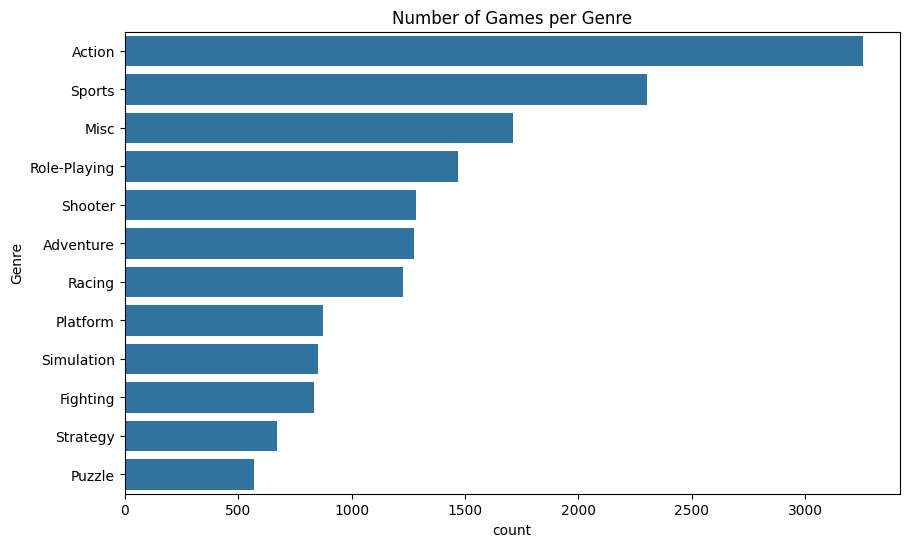

In [19]:
plt.figure(figsize=(10,6))
order = df['Genre'].value_counts().index
sns.countplot(data=df, y='Genre', order=order)
plt.title("Number of Games per Genre")
plt.show()


## ***Top 12 publishers by number of games***

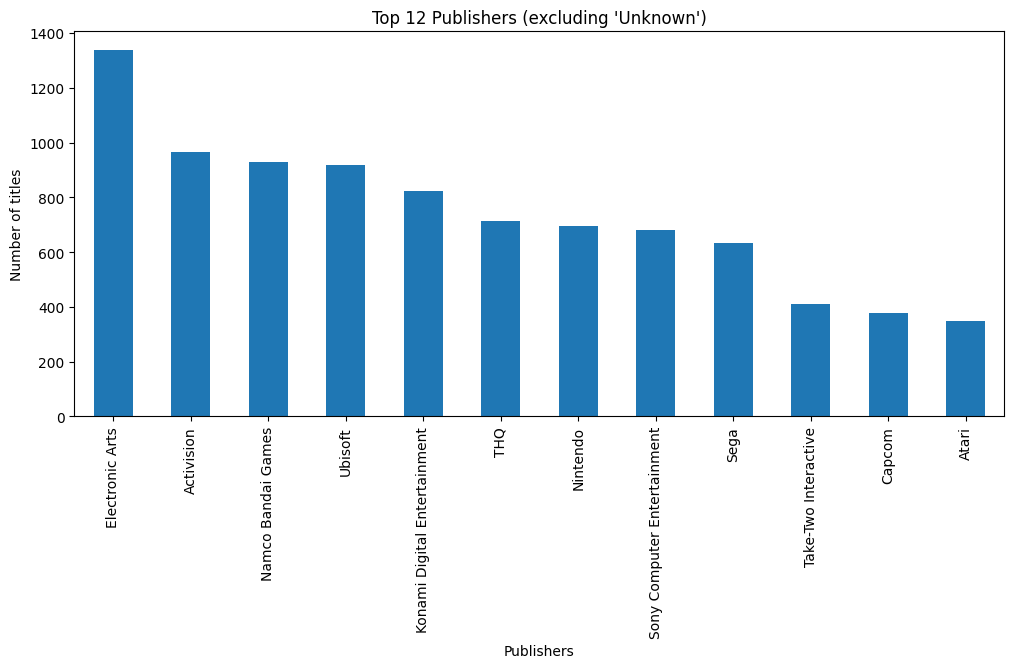

In [20]:
plt.figure(figsize=(12,5))

(df[df['Publishers'] != 'Unknown']['Publishers']
     .value_counts()
     .head(12)
     .plot(kind='bar'))

plt.title("Top 12 Publishers (excluding 'Unknown')")
plt.ylabel("Number of titles")
plt.show()



## ***Success rate by genre (proportion)***

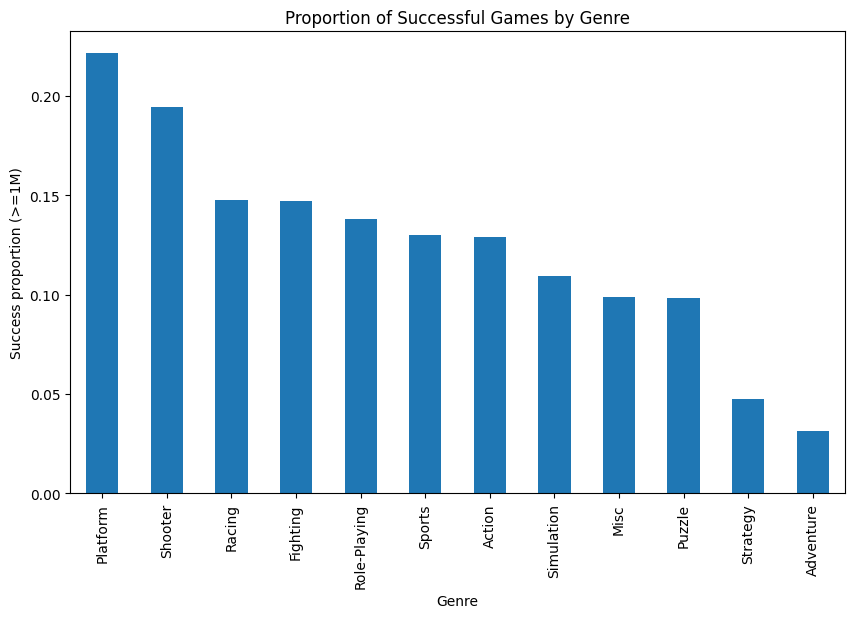

In [21]:
genre_success = df.groupby('Genre')['Success'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
genre_success.plot(kind='bar')
plt.title("Proportion of Successful Games by Genre")
plt.ylabel("Success proportion (>=1M)")
plt.show()


## ***4.5 Success rate by platform (heat / bar)***

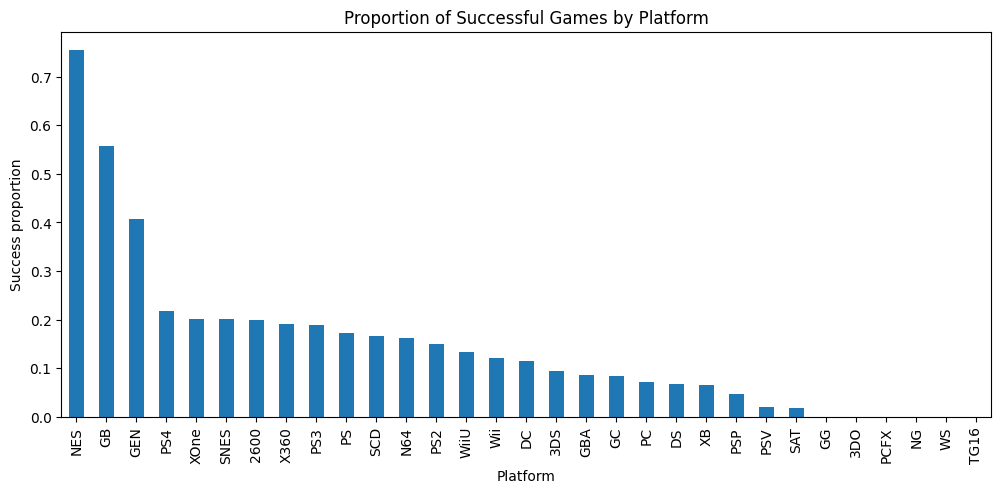

In [22]:
platform_success = df.groupby('Platform')['Success'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,5))
platform_success.plot(kind='bar')
plt.title("Proportion of Successful Games by Platform")
plt.ylabel("Success proportion")
plt.show()


## **Training split & Selecting features**

In [23]:
from sklearn.model_selection import train_test_split

features = ['Platform','Year','Genre','Publishers']
X = df[features].copy()
y = df['Success'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)



Train shape: (13061, 4) Test shape: (3266, 4)


## **Building preprocessing pipeline (ColumnTransformer)**

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

categorical_cols = ['Platform','Genre','Publishers']
numeric_cols = ['Year']

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_cols),
    ('num', num_pipe, numeric_cols),
], sparse_threshold=0.3)

_ = preprocessor.fit_transform(X_train)
print("Preprocessor fitted.")


Preprocessor fitted.


# **Utility: train/evaluate shortcut**

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score

def fit_and_report(estimator, name="model", X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test):

    if hasattr(estimator, "predict") and not hasattr(estimator, "fit") and False:
        pass
    if not hasattr(estimator, "predict") or 'pre' not in getattr(estimator, '__class__', type(estimator)).__name__.lower():
        model = Pipeline([('pre', preprocessor), ('clf', estimator)])
    else:
        model = estimator

    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    proba = None
    try:
        proba = model.predict_proba(X_te)[:,1]
    except Exception:
        proba = None

    print("=== Results for", name, "===")
    print(classification_report(y_te, preds))
    if proba is not None:
        try:
            print("ROC AUC:", roc_auc_score(y_te, proba))
        except Exception:
            pass
    return model


# **Model 1: Logistic Regression**

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga', max_iter=2000, class_weight='balanced', random_state=42)
lr_pipe = Pipeline([('pre', preprocessor), ('clf', lr)])

lr_model = fit_and_report(lr, name="LogisticRegression (baseline)")


=== Results for LogisticRegression (baseline) ===
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2854
           1       0.28      0.73      0.40       412

    accuracy                           0.73      3266
   macro avg       0.61      0.73      0.61      3266
weighted avg       0.86      0.73      0.77      3266

ROC AUC: 0.8120348038181806


# **Model 2: Random Forest**

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model = fit_and_report(rf, name="RandomForest (baseline)")

=== Results for RandomForest (baseline) ===
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2854
           1       0.37      0.45      0.40       412

    accuracy                           0.83      3266
   macro avg       0.64      0.67      0.65      3266
weighted avg       0.85      0.83      0.84      3266

ROC AUC: 0.7976128717317205


# **Model 3: ExtraTrees**

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
et_model = fit_and_report(et, name="ExtraTrees (baseline)")


=== Results for ExtraTrees (baseline) ===
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2854
           1       0.32      0.51      0.40       412

    accuracy                           0.80      3266
   macro avg       0.62      0.68      0.64      3266
weighted avg       0.85      0.80      0.82      3266

ROC AUC: 0.7224841135929134


# **Model 4: LightGBM**

In [29]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(n_estimators=150, objective='binary', random_state=42, n_jobs=-1)
lgb_model = fit_and_report(lgb, name="LightGBM (baseline)")


[LightGBM] [Info] Number of positive: 1647, number of negative: 11414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 13061, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126101 -> initscore=-1.935885
[LightGBM] [Info] Start training from score -1.935885
=== Results for LightGBM (baseline) ===
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2854
           1       0.68      0.24      0.36       412

    accuracy                           0.89      3266
   macro avg       0.79      0.61      0.65      3266
weighted avg       0.87      0.89      0.87      3266

ROC AUC: 0.8512686163517733


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# **Model 5: XGBoost**

In [30]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=150, random_state=42, n_jobs=-1)
xgb_model = fit_and_report(xgb, name="XGBoost (baseline)")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:04:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Results for XGBoost (baseline) ===
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2854
           1       0.60      0.27      0.37       412

    accuracy                           0.89      3266
   macro avg       0.75      0.62      0.66      3266
weighted avg       0.86      0.89      0.87      3266

ROC AUC: 0.8484918969118458


# **Hyperparamter Tuning (RandomizedSearchCV)**

In [31]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import randint, uniform, loguniform
import numpy as np
import joblib
import warnings
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
n_iter = 50   # If for some reason this cell isn't comitted, professor can reduce this number for speed, as this cell took a high amount of time to run.

def run_random_search(pipe, param_dist, name, n_iter=n_iter, cv=cv):
    rs = RandomizedSearchCV(pipe, param_distributions=param_dist,
                            n_iter=n_iter, cv=cv, scoring='f1',
                            random_state=42, n_jobs=-1, verbose=2, error_score=np.nan)
    rs.fit(X_train, y_train)
    best = rs.best_estimator_
    print(f"\n{name} best params:\n", rs.best_params_)
    preds = best.predict(X_test)
    print(f"\n{name} test classification report:")
    print(classification_report(y_test, preds))
    try:
        print("ROC AUC:", roc_auc_score(y_test, best.predict_proba(X_test)[:,1]))
    except Exception:
        pass
    joblib.dump(rs, f"rs_{name}.pkl")
    return rs, best

# 1) Logistic Regression

lr_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(solver='saga', max_iter=10000, class_weight='balanced', random_state=42))])
lr_param = {
    'clf__C': loguniform(1e-4, 1e2),
    'clf__penalty': ['l2', 'elasticnet'],
    'clf__l1_ratio': uniform(0,1)
}
rs_lr, best_lr = run_random_search(lr_pipe, lr_param, "LogisticRegression")


# 2) Random Forest

rf_pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))])
rf_param = {
    'clf__n_estimators': randint(100, 600),
    'clf__max_depth': [None, 10, 20, 30, 40, 60],
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 8),
    'clf__max_features': ['sqrt','log2', 0.3, 0.5, None],
    'clf__bootstrap': [True, False]
}
rs_rf, best_rf = run_random_search(rf_pipe, rf_param, "RandomForest")


# 3) ExtraTrees

et_pipe = Pipeline([('pre', preprocessor), ('clf', ExtraTreesClassifier(class_weight='balanced', random_state=42, n_jobs=-1))])
et_param = {
    'clf__n_estimators': randint(100, 500),
    'clf__max_depth': [None, 10, 20, 40],
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1,6),
    'clf__max_features': ['sqrt','log2', 0.5]
}
rs_et, best_et = run_random_search(et_pipe, et_param, "ExtraTrees")


# 4) LightGBM

lgb_pipe = Pipeline([('pre', preprocessor), ('clf', LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, verbose=-1))])
lgb_param = {
    'clf__n_estimators': randint(100, 500),
    'clf__learning_rate': loguniform(1e-3, 0.3),
    'clf__num_leaves': randint(10, 200),
    'clf__max_depth': [-1, 6, 10, 15, 25],
    'clf__min_child_samples': randint(5, 50),
    'clf__subsample': uniform(0.5, 0.5),
    'clf__colsample_bytree': uniform(0.5, 0.5)
}
rs_lgb, best_lgb = run_random_search(lgb_pipe, lgb_param, "LightGBM")


# 5) XGBoost

xgb_pipe = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1, verbosity=0))])
xgb_param = {
    'clf__n_estimators': randint(100, 500),
    'clf__learning_rate': loguniform(1e-3, 0.3),
    'clf__max_depth': randint(3, 12),
    'clf__subsample': uniform(0.5, 0.5),
    'clf__colsample_bytree': uniform(0.5, 0.5),
    'clf__gamma': uniform(0, 1)
}
rs_xgb, best_xgb = run_random_search(xgb_pipe, xgb_param, "XGBoost")


Fitting 4 folds for each of 50 candidates, totalling 200 fits

LogisticRegression best params:
 {'clf__C': np.float64(0.13335385049873044), 'clf__l1_ratio': np.float64(0.9611720243493491), 'clf__penalty': 'l2'}

LogisticRegression test classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      2854
           1       0.28      0.72      0.40       412

    accuracy                           0.73      3266
   macro avg       0.61      0.72      0.61      3266
weighted avg       0.86      0.73      0.77      3266

ROC AUC: 0.8112625951653616
Fitting 4 folds for each of 50 candidates, totalling 200 fits

RandomForest best params:
 {'clf__bootstrap': True, 'clf__max_depth': 60, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 13, 'clf__n_estimators': 394}

RandomForest test classification report:
              precision    recall  f1-score   support

           0       0.95      0.85      

# **Model Comparison Table**

Models included: ['Logistic Regression', 'Random Forest', 'ExtraTrees', 'LightGBM', 'XGBoost']

Model comparison (rounded):


,Accuracy,Precision (1),Recall (1),F1 (1),ROC AUC
Model,,,,,
Random Forest,0.825,0.387,0.667,0.490,0.847
ExtraTrees,0.785,0.334,0.709,0.454,0.841
LightGBM,0.883,0.565,0.325,0.413,0.836
Logistic Regression,0.730,0.278,0.716,0.401,0.811
XGBoost,0.887,0.604,0.296,0.397,0.848


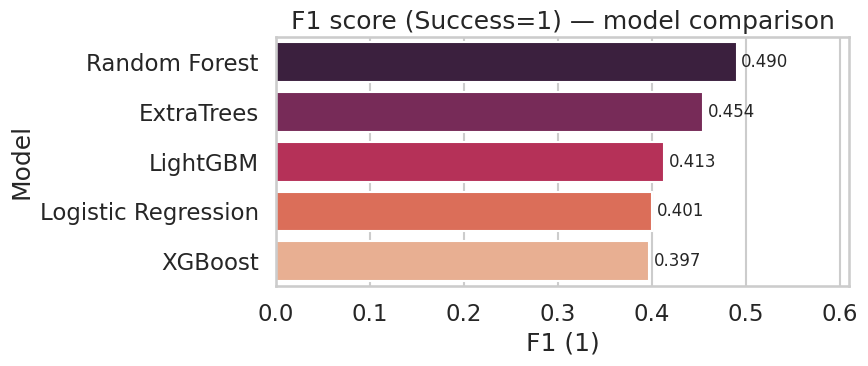

In [32]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

sns.set(style='whitegrid', context='talk', rc={'figure.figsize':(10,6)})

g = globals()
candidate_keys = [
    ('best_lr', 'Logistic Regression'),
    ('best_logreg', 'Logistic Regression'),
    ('best_rf', 'Random Forest'),
    ('best_randomforest', 'Random Forest'),
    ('best_rf_safe', 'Random Forest (safe)'),
    ('best_et', 'ExtraTrees'),
    ('best_extratrees', 'ExtraTrees'),
    ('best_et_safe', 'ExtraTrees (safe)'),
    ('best_lgb', 'LightGBM'),
    ('best_lightgbm', 'LightGBM'),
    ('best_lgb_safe', 'LightGBM (safe)'),
    ('best_xgb', 'XGBoost'),
    ('best_xgboost', 'XGBoost'),
    ('best_xgb_safe', 'XGBoost (safe)'),
]

models_found = {}
for var, pretty in candidate_keys:
    if var in g and var not in models_found:
        models_found[pretty] = g[var]

if not models_found:
    for k,v in g.items():
        if (k.lower().startswith(('best_','final_','optuna_best','rs_')) or 'pipeline' in k.lower()) and hasattr(v, 'predict'):
            label = k
            if label in models_found:
                label = f"{k}_{len(models_found)}"
            models_found[label] = v

print("Models included:", list(models_found.keys()))

rows = []
def safe_proba(m, X):
    try:
        return m.predict_proba(X)[:,1]
    except Exception:
        try:
            if hasattr(m, 'named_steps') and 'clf' in m.named_steps and 'pre' in m.named_steps:
                Xt = m.named_steps['pre'].transform(X)
                return m.named_steps['clf'].predict_proba(Xt)[:,1]
        except Exception:
            return None

for name, model in models_found.items():
    try:
        y_pred = model.predict(X_test)
        proba = safe_proba(model, X_test)
        acc = accuracy_score(y_test, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0,1])
        roc = roc_auc_score(y_test, proba) if proba is not None else np.nan
        rows.append({
            'Model': name,
            'Accuracy': acc,
            'Precision (1)': p[1],
            'Recall (1)': r[1],
            'F1 (1)': f1[1],
            'ROC AUC': roc
        })
    except Exception as e:
        print(f"Skipping {name}: {e}")

df_comp_pretty = pd.DataFrame(rows).set_index('Model')
df_comp_pretty = df_comp_pretty.sort_values('F1 (1)', ascending=False)

df_display = df_comp_pretty.copy()
for col in df_display.columns:
    df_display[col] = df_display[col].apply(lambda v: f"{v:.3f}" if pd.notnull(v) else "n/a")

print("\nModel comparison (rounded):")
display(df_display)

plt.figure(figsize=(9, max(4, 0.6*len(df_comp_pretty))))
sns.barplot(x='F1 (1)', y=df_comp_pretty.index, data=df_comp_pretty.reset_index(), palette='rocket')
plt.title("F1 score (Success=1) — model comparison")
for i, (val) in enumerate(df_comp_pretty['F1 (1)'].values):
    plt.text(val + 0.005, i, f"{val:.3f}", va='center', fontsize=12)
plt.xlim(0, df_comp_pretty['F1 (1)'].max() + 0.12)
plt.tight_layout()
plt.show()


# ROC **Curves**

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

if 'df_comp' in globals():
    plt.figure(figsize=(8,6))
    found_any = False
    for name in df_comp.index:
        model = models.get(name)
        proba = safe_proba(model, X_test)

        if proba is None:
            print(f"Skipping ROC for {name}: no predict_proba available")
            continue

        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        found_any = True

    plt.plot([0,1],[0,1],'k--', alpha=0.4)
    if found_any:
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves — comparison")
        plt.legend(loc='lower right', fontsize='small')
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print("No models with predict_proba found for ROC plotting.")


# **Confusion Matrices**

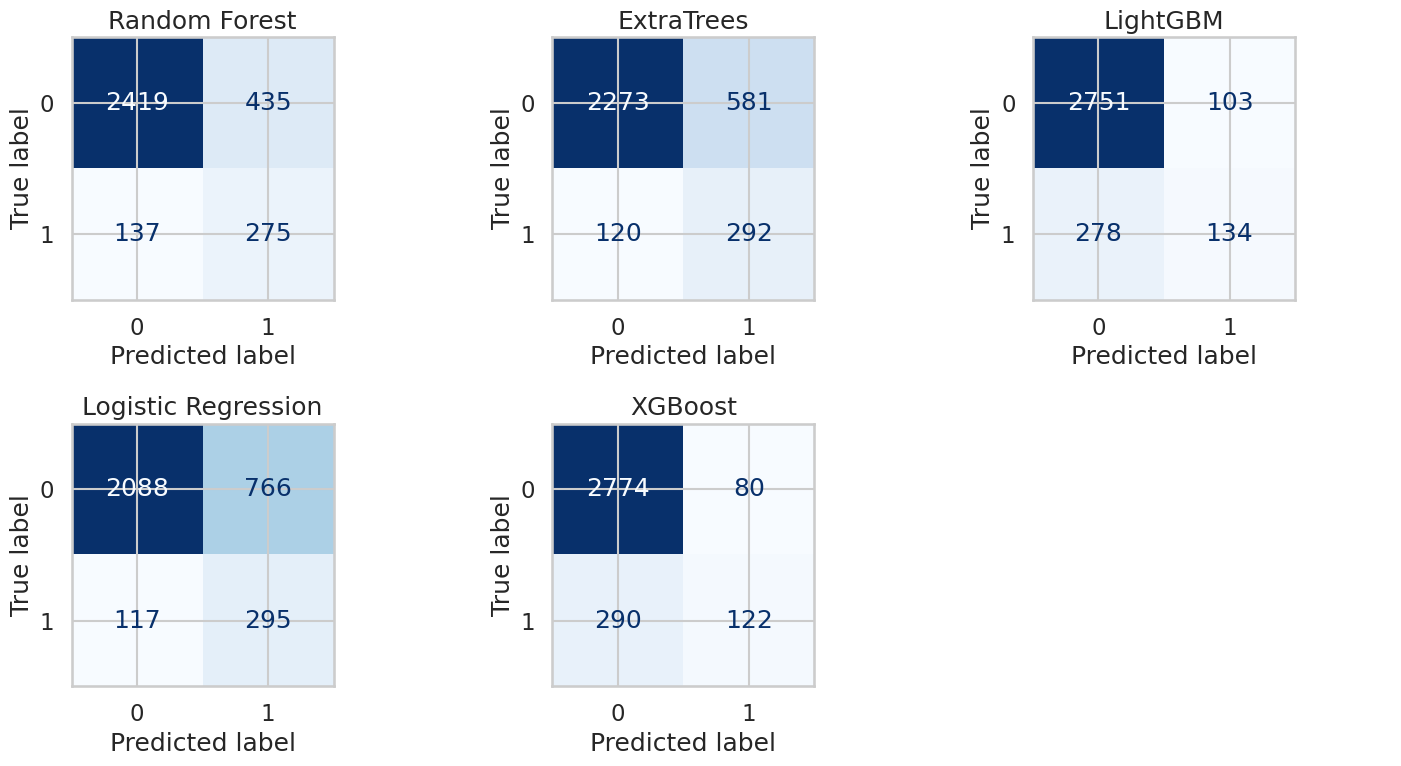

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import math
import matplotlib.pyplot as plt

if 'models_found' in globals() or  models_found:

    names_to_plot = list(df_comp_pretty.index)
    n = len(names_to_plot)
    cols = 3
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, name in enumerate(names_to_plot):
        ax = axes[i]
        model = models_found[name]
        try:
            y_pred = model.predict(X_test)
            disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
            ax.set_title(name)
        except Exception as e:
            ax.text(0.5, 0.5, f"Skip {name}\n{e}", ha='center', va='center')
            ax.set_title(name)

    for i in range(len(names_to_plot), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# **Feature Importance**

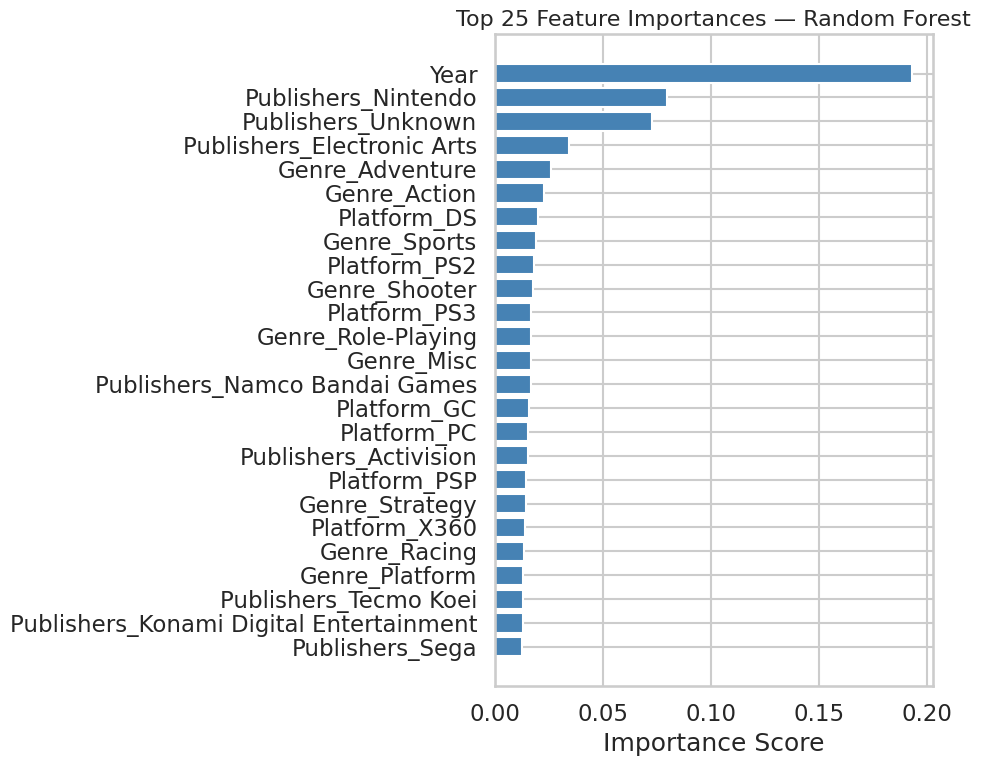

,Feature,Importance
73,Year,0.192826
60,Publishers_Nintendo,0.079745
69,Publishers_Unknown,0.072874
53,Publishers_Electronic Arts,0.034503
32,Genre_Adventure,0.025906
31,Genre_Action,0.022695
4,Platform_DS,0.019816
41,Genre_Sports,0.018945
16,Platform_PS2,0.017959
39,Genre_Shooter,0.017835


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_clean_feature_names(preprocessor):
    """Extract readable feature names from ColumnTransformer with OneHotEncoder."""
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == "remainder":
            continue

        if hasattr(transformer, "named_steps"):
            step = transformer.named_steps.get("ohe", None)
            if step and hasattr(step, "get_feature_names_out"):
                ohe_names = step.get_feature_names_out(cols)
                feature_names.extend(ohe_names)
            else:
                feature_names.extend(cols)

        else:
            if hasattr(transformer, "get_feature_names_out"):
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)

    return feature_names


def plot_feature_importances(model, model_name="Model", top_n=25):
    """Plot feature importances with readable names."""
    if hasattr(model, "named_steps"):
        pre = model.named_steps["pre"]
        clf = model.named_steps["clf"]
    else:
        print("Model is not a pipeline.")
        return

    if not hasattr(clf, "feature_importances_"):
        print("Model does not expose feature_importances_.")
        return

    importances = clf.feature_importances_

    feature_names = get_clean_feature_names(pre)

    if len(feature_names) != len(importances):
        print("Warning: length mismatch. Falling back to generic names.")
        feature_names = [f"f{i}" for i in range(len(importances))]

    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    plt.barh(df_imp["Feature"][::-1], df_imp["Importance"][::-1], color="steelblue")
    plt.title(f"Top {top_n} Feature Importances — {model_name}", fontsize=16)
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    display(df_imp)


plot_feature_importances(best_rf, model_name="Random Forest")
